# Coding: Machine Translation (RNN + Attention)

 - Dataset: wmt-17, en-zh, select 1m high-quality pairs of data
 - Model: Seq2seq with RNN + Attention
 - GPU: 1660TI

In [1]:
# 可以先测试网络连接
import requests
try:
    response = requests.get("https://huggingface.co")
    print("网络连接正常")
except:
    print("网络连接可能存在问题")

网络连接正常


In [2]:
# Download the data & select 5m high-quality pairs

from datasets import load_dataset
import re

# load full wmt-17 en-zh dataset
full_dataset = load_dataset("wmt/wmt17", "zh-en", split="train", cache_dir=r"D:\Developer\LLM\FuggingFace-cache-model")

# Length & Ratio filter
def is_high_quality(x):
    import re  # 添加这一行
    en = x["translation"]["en"]
    zh = x["translation"]["zh"]
    if not en or not zh:
        return False
    if len(en) < 3 or len(zh) < 3:
        return False
    if len(en) > 100 or len(zh) > 100:
        return False
    ratio = len(en) / len(zh)
    if ratio < 0.5 or ratio > 2:
        return False
    if not re.search(r'[\u4e00-\u9fff]', zh):
        return False
    return True

filtered_dataset = full_dataset.filter(is_high_quality, num_proc=10)

# 选出最多500万条数据
dataset = filtered_dataset.select(range(min(5_000_000, len(filtered_dataset))))

print("Full Dataset Size: ", len(full_dataset))
print("Filtered Dataset Size: ", len(filtered_dataset))
print("Dataset Size: ", len(dataset))

# print 10 samples
sample = dataset.shuffle(seed=42).select(range(10))
print("-"*100)
for i in sample:
    print(i["translation"]["en"])
    print(i["translation"]["zh"])
    print("-"*100)

Using the latest cached version of the dataset since wmt/wmt17 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'zh-en' at D:\Developer\LLM\FuggingFace-cache-model\wmt___wmt17\zh-en\0.0.0\54d3aacfb5429020b9b85b170a677e4bc92f2449 (last modified on Sun Aug 17 21:48:42 2025).


Full Dataset Size:  25134743
Filtered Dataset Size:  1141860
Dataset Size:  1141860
----------------------------------------------------------------------------------------------------
Zambia (7)
赞比亚(7)
----------------------------------------------------------------------------------------------------
15:00 to 18:00 Informal consultations (closed) Conference Room 5 (NLB)
下午3:00－6:00 非正式磋商(闭门会议) 第5会议室(北草坪会议大楼)
----------------------------------------------------------------------------------------------------
Spain
西班牙
----------------------------------------------------------------------------------------------------
Mr. Robert Morrison
Robert Morrison先生 加拿大自然资源部
----------------------------------------------------------------------------------------------------
This satisfied the kids, but not the husband.
"孩子们得到了满意的答案, 但她的丈夫却没有。
----------------------------------------------------------------------------------------------------
Shutaro Omura (Japan)
Shutaro Omura（日本）
---------------

In [3]:
# Create PyTorch Dataset and DataLoader for training

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# 继承Dataset构建英中文翻译数据集
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer_en, tokenizer_zh, max_length=100):
        """
        PyTorch Dataset wrapper for HuggingFace translation dataset

        Args:
            hf_dataset: HuggingFace dataset with translation pairs
            tokenizer_en: English tokenizer (optional, can be added later)
            tokenizer_zh: Chinese tokenizer (optional, can be added later)
            max_length: Maximum sequence length
        """
        self.dataset = hf_dataset
        self.tokenizer_en = tokenizer_en
        self.tokenizer_zh = tokenizer_zh
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        en_text = item["translation"]["en"]
        zh_text = item["translation"]["zh"]

        # 对英文文本进行tokenizer，截取max_length，不够会进行填充，返回pytorch张量
        en_tokens = self.tokenizer_en(en_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        # 对中文文本进行tokenizer，截取max_length，不够会进行填充，返回pytorch张量
        zh_tokens = self.tokenizer_zh(zh_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        # 返回数据结构
        return {
                'source_ids': en_tokens['input_ids'].squeeze(),     # 去除张量的多余维度，输出以为数字数组，文本对应的tokenizer后的数组
                'target_ids': zh_tokens['input_ids'].squeeze(),
                'source_text': en_text,         # 原始文本
                'target_text': zh_text
        }

# 构建训练和验证数据集
def create_dataloaders(dataset, batch_size=128, num_workers=0, train_split=0.95):
    """
    Create train and validation DataLoaders from HuggingFace dataset

    Args:
        dataset: HuggingFace dataset with translation pairs
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for data loading
        train_split: Fraction of data to use for training

    Returns:
        train_dataloader, val_dataloader, train_dataset, val_dataset
    """

    # Split dataset into train and validation
    train_size = int(train_split * len(dataset))

    # Create indices for splitting
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices,
                                                train_size=train_size,
                                                random_state=42)

    # Create train and validation datasets
    train_dataset_hf = dataset.select(train_indices)
    val_dataset_hf = dataset.select(val_indices)

    # tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

    # get vocab sizes
    vocab_size_en = tokenizer_en.vocab_size
    vocab_size_zh = tokenizer_zh.vocab_size

    print(f"Vocab size for en: {vocab_size_en}")
    print(f"Vocab size for zh: {vocab_size_zh}")

    # Create PyTorch datasets， 得到tokenizer后的训练数据集和验证数据集
    train_dataset = TranslationDataset(train_dataset_hf, tokenizer_en, tokenizer_zh)
    val_dataset = TranslationDataset(val_dataset_hf, tokenizer_en, tokenizer_zh)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Create DataLoaders 创建了pytorch数据加载器，封装了数据集，并定义了batch_size，shuffle，num_workers，方便训练时设置数据加载相关的超参数
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Train DataLoader: {len(train_dataloader)} batches")
    print(f"Validation DataLoader: {len(val_dataloader)} batches")

    return train_dataloader, val_dataloader, vocab_size_en, vocab_size_zh

def test_dataloader(dataloader):
    """Test the DataLoader by printing a sample batch"""
    print("\n" + "="*50)
    print("Sample batch from DataLoader:")
    print("="*50)

    for batch in dataloader:
        print(f"Batch size: {len(batch['source_text'])}")
        print(f"Source example: {batch['source_text'][0]}")
        print(f"Source tokens: {batch['source_ids'][0]}")
        print(f"Target example: {batch['target_text'][0]}")
        print(f"Target tokens: {batch['target_ids'][0]}")
        break

train_dataloader, val_dataloader, encoder_vocab_size, decoder_vocab_size = create_dataloaders(dataset, batch_size=64)
test_dataloader(train_dataloader)
test_dataloader(val_dataloader)

Vocab size for en: 30522
Vocab size for zh: 21128
Train dataset size: 1084767
Validation dataset size: 57093
Train DataLoader: 16950 batches
Validation DataLoader: 893 batches

Sample batch from DataLoader:
Batch size: 64
Source example: Iraq
Source tokens: tensor([ 101, 5712,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Target example: 伊拉克
Target tokens: tensor([ 101,  823, 2861, 1046,  1

In [4]:
# Define the Seq2Seq model with GRU + Attention

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Attention网络结构
class Attention(nn.Module):
    """
    QKV Attention mechanism for Seq2Seq models
    """
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

        # QKV transformations，bias=False 在这里是为了简化注意力机制中的线性变换，减少不必要的参数，同时不会显著影响模型性能
        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)  # Query projection
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)  # Key projection
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)  # Value projection

    # Encoder-Decoder attention
    def forward(self, encoder_outputs, decoder_hidden):
        """
        Compute attention weights and context vector

        Args:
            encoder_outputs: [batch_size, seq_len, hidden_size]     编码器所有时间步的隐藏状态
            decoder_hidden: [batch_size, hidden_size]   解码器当前时间步的隐藏状态

        Returns:
            context: [batch_size, hidden_size]  上下文向量 context 包含了编码器输出中与当前解码器状态最相关的信息（融合信息）
            attention_weights: [batch_size, seq_len]    代表着当前时间步的解码器状态与编码器所有时间步的隐藏状态的相似度（概率值），每个权重表示对应位置的重要性
        """
        # Q: Transform decoder hidden state 解码器当前时间步的隐藏状态的转化
        Q = self.W_q(decoder_hidden.unsqueeze(1))  # [batch_size, hidden_size] 加维度 [batch_size, 1, hidden_size] 线性变化 [batch_size, 1, hidden_size]

        # K, V: Transform encoder outputs 编码器所有时间步的隐藏状态的转化
        K = self.W_k(encoder_outputs)  # [batch_size, seq_len, hidden_size] 线性变化 [batch_size, seq_len, hidden_size]
        V = self.W_v(encoder_outputs)  # [batch_size, seq_len, hidden_size] 线性变化 [batch_size, seq_len, hidden_size]

        '''
        Scaled dot-product attention（缩放点积注意力机制）
            1、计算查询（Q）和键（K）之间的相似度得分
            2、使用 softmax 将得分转换为权重
            3、使用这些权重对值（V）进行加权求和
        '''
        # K.transpose(1, 2) [batch_size, hidden_size, seq_len]
        # Q.bmm(K.transpose(1, 2)) # [batch_size, 1, seq_len] 注意力分数矩阵，代表着当前时间步的输入与编码器所有时间步的隐藏状态的相似度（分数值）
        scores = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(self.hidden_size)
        # attention_weights: [batch_size, seq_len]  将注意力分数转换为概率分布（注意力权重），代表着当前时间步的输入与编码器所有时间步的隐藏状态的相似度（概率值），每个权重表示对应位置的重要性
        attention_weights = F.softmax(scores.squeeze(1), dim=1)
        # attention_weights.unsqueeze(1) 在第1维添加一个维度，变为 [batch_size, 1, seq_len]
        # V  [batch_size, seq_len, hidden_size]
        # torch.bmm(attention_weights.unsqueeze(1), V) 这一步实现了对编码器各个时间步的加权求和 [batch_size, 1, hidden_size]
        # Context vector: 移除第1维(大小为1的维度)得到[batch_size, hidden_size]，生成的上下文向量 context 包含了编码器输出中与当前解码器状态最相关的信息
        context = torch.bmm(attention_weights.unsqueeze(1), V).squeeze(1)

        return context, attention_weights

# 编码器
class Encoder(nn.Module):
    """
    Encoder component of the Seq2Seq model using GRU
    Processes the input sequence and generates context vectors
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Encoder, self).__init__()

        # 编码层网络超参数
        self.vocab_size = vocab_size        # 这个是固定的，字典的大小，和具体的语言和具体的tokenizer实现有关
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer to convert token IDs to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # GRU layer for processing sequences
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout, bidirectional=False)

    def forward(self, input_seq):
        """
        Forward pass of the encoder

        Args:
            input_seq: Input token sequences [batch_size, seq_len]
            input_lengths: Actual lengths of sequences (for packed sequences)

        Returns:
            outputs: All hidden states [batch_size, seq_len, hidden_size]
            hidden: Final hidden state [num_layers, batch_size, hidden_size]
        """

        # Convert token IDs to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]

        # Pass through GRU
        # outputs: All hidden states [batch_size, seq_len, hidden_size]
        # hidden: Final hidden state [num_layers, batch_size, hidden_size]
        outputs, hidden = self.rnn(embedded)

        # outputs: [batch_size, seq_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        return outputs, hidden

# 解码器
class Decoder(nn.Module):
    """
    Decoder component of the Seq2Seq model using GRU with Attention
    Generates output sequence one token at a time
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Decoder, self).__init__()

        # 解码器网络超参数
        self.vocab_size = vocab_size        # 这个是固定的，字典的大小，和具体的语言和具体的tokenizer实现有关
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer for target tokens
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Attention mechanism
        self.attention = Attention(hidden_size)

        # GRU layer for generating sequences (input: embedding + context)
        # 解码器中的每一层rnn的输入是embedding和context的拼接
        self.rnn = nn.GRU(embed_size + hidden_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout, bidirectional=False)

        # Output projection layer to vocabulary (input: GRU output)
        self.output_projection = nn.Linear(hidden_size, vocab_size)

    # 解码器中的前向计算中的每一步
    def forward(self, input_token, hidden, encoder_outputs):
        """
        Forward pass of the decoder with attention (single step)
        TODO: the logic of this function is inconsistent with the forward_seq function, need to fix it

        Args:
            input_token: Current input token [batch_size, 1]  单词
            hidden: Hidden state from encoder/previous step [num_layers, batch_size, hidden_size]
            encoder_outputs: All encoder outputs [batch_size, seq_len, hidden_size]

        Returns:
            output: Vocabulary predictions [batch_size, vocab_size]
            hidden: Updated hidden state [num_layers, batch_size, hidden_size]
            attention_weights: Attention weights [batch_size, seq_len]
        """
        # input_token: [batch_size, 1]
        embedded = self.embedding(input_token)  # [batch_size, 1, embed_size]

        # Use the top layer hidden state for attention computation，获取输入的hidden中最后一层的隐藏状态
        decoder_hidden_for_attention = hidden[-1]  # [batch_size, hidden_size]

        # Compute attention context
        context, attention_weights = self.attention(encoder_outputs, decoder_hidden_for_attention)
        # context: [batch_size, hidden_size]
        # attention_weights: [batch_size, seq_len]

        # Concatenate embedding with context vector
        rnn_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)
        # rnn_input: [batch_size, 1, embed_size + hidden_size]

        # Pass through GRU
        gru_out, hidden = self.rnn(rnn_input, hidden)
        # gru_out: [batch_size, 1, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]

        # Concatenate GRU output with context for final projection
        output_input = gru_out.squeeze(1)
        # output_input: [batch_size, hidden_size]

        # Project to vocabulary
        output = self.output_projection(output_input)  # [batch_size, vocab_size]

        # output：[batch_size, vocab_size] 预测的下一个单词的概率
        # hidden：[num_layers, batch_size, hidden_size] 隐藏状态，下一个时间步的隐藏状态输入
        # attention_weights：[batch_size, seq_len]，代表着当前时间步的解码器状态与编码器所有时间步的隐藏状态的相似度（概率值），每个权重表示对应位置的重要性
        return output, hidden, attention_weights

    # 这个是针对训练优化的前向计算流程，目的是为了加速训练，原本一个单词一个单词预测的方式太慢了，将串行改为并行处理，加速训练
    def forward_seq(self, input_seq, hidden, encoder_outputs):
        """
        ⚡ FAST Sequence forward for training with attention (teacher forcing)
        Vectorized implementation without loops for parallel processing

        Args:
            input_seq: Target sequence [batch_size, seq_len]
            hidden: Initial hidden state [num_layers, batch_size, hidden_size]
            encoder_outputs: All encoder hidden states [batch_size, seq_len, hidden_size]

        Returns:
            outputs: Vocabulary predictions [batch_size, seq_len, vocab_size]
            final_hidden: Final hidden state [num_layers, batch_size, hidden_size]
        """
        batch_size, seq_len = input_seq.shape

        # Embed the entire sequence
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]

        # Step 1: Get all decoder hidden states by running GRU with encoder context
        encoder_hidden_context = hidden[-1].unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, seq_len, hidden_size]
        temp_input = torch.cat([embedded, encoder_hidden_context], dim=2)  # [batch_size, seq_len, embed_size + hidden_size]
        temp_gru_out, temp_hidden = self.rnn(temp_input, hidden)
        # temp_gru_out: [batch_size, seq_len, hidden_size]

        # Step 2: Extract decoder hidden states for attention computation
        # For multi-layer GRU, we use the top layer outputs for attention
        decoder_hiddens = temp_gru_out  # [batch_size, seq_len, hidden_size]

        # Step 3: Compute attention contexts for all timesteps in parallel
        # Reshape to process all timesteps at once
        decoder_hiddens_reshaped = decoder_hiddens.reshape(-1, self.hidden_size)  # [batch_size * seq_len, hidden_size]
        encoder_outputs_expanded = encoder_outputs.unsqueeze(1).expand(-1, seq_len, -1, -1).contiguous()
        encoder_outputs_reshaped = encoder_outputs_expanded.reshape(-1, encoder_outputs.size(1), self.hidden_size)
        # encoder_outputs_reshaped: [batch_size * seq_len, source_len, hidden_size]

        # Compute attention for all decoder steps at once
        contexts, _ = self.attention(encoder_outputs_reshaped, decoder_hiddens_reshaped)
        # contexts: [batch_size * seq_len, hidden_size]

        # Reshape contexts back
        contexts = contexts.reshape(batch_size, seq_len, self.hidden_size)  # [batch_size, seq_len, hidden_size]

        # Step 4: Concatenate embeddings with contexts and recompute GRU
        enhanced_input = torch.cat([embedded, contexts], dim=2)  # [batch_size, seq_len, embed_size + hidden_size]

        # Final GRU pass with attention-enhanced input
        gru_out, final_hidden = self.rnn(enhanced_input, hidden)
        # gru_out: [batch_size, seq_len, hidden_size]

        # Step 5: Project to vocabulary for all timesteps
        outputs = self.output_projection(gru_out)  # [batch_size, seq_len, vocab_size]

        # outputs：[batch_size, seq_len, vocab_size]，预测字段序列结果
        # final_hidden：[num_layers, batch_size, hidden_size] ，最终的隐藏状态
        return outputs, final_hidden

class Seq2Seq(nn.Module):
    """
    Complete Sequence-to-Sequence model using GRU
    Combines Encoder and Decoder for translation
    """
    def __init__(self, encoder_vocab_size, decoder_vocab_size, embed_size=512,
                 hidden_size=1024, num_layers=2, dropout=0.1):
        super(Seq2Seq, self).__init__()

        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize encoder and decoder
        self.encoder = Encoder(encoder_vocab_size, embed_size, hidden_size, num_layers, dropout)
        self.decoder = Decoder(decoder_vocab_size, embed_size, hidden_size, num_layers, dropout)

    # 模型训练前向计算实现
    def forward(self, source_seq, target_seq):
        """
        ⚡ Training forward with attention mechanism

        Args:
            source_seq: Source sequence [batch_size, seq_len]
            target_seq: Target sequence [batch_size, target_len]

        Returns:
            outputs: Vocabulary predictions [batch_size, target_len, decoder_vocab_size]
        """
        # Encode source sequence
        encoder_outputs, hidden = self.encoder(source_seq)
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]

        # Decode with attention
        outputs, _ = self.decoder.forward_seq(target_seq, hidden, encoder_outputs)
        # outputs: [batch_size, seq_len, output_size]，目标序列的预测结果

        return outputs

    # 预测生成（根据翻译的输入字段序列生成翻译结果字段序列）
    def generate(self, source_seq, max_length=100, start_token=101, end_token=102):
        """
        Generate translation for given source sequence with attention (inference mode)

        Args:
            source_seq: Source sequence [batch_size, source_len]
            max_length: Maximum length of generated sequence
            start_token: BOS token ID (101 for BERT)
            end_token: EOS token ID (102 for BERT)

        Returns:
            generated_seq: Generated sequence [batch_size, generated_len]
            attention_weights: Attention weights for each generated token [batch_size, generated_len, source_len]
        """
        self.eval()
        batch_size = source_seq.size(0)

        with torch.no_grad():
            # Encode source sequence
            encoder_outputs, hidden = self.encoder(source_seq)
            # encoder_outputs: [batch_size, source_len, hidden_size]

            # Initialize with start token: [batch_size, 1] 生成预测的第一个输入单词，即BOS token ID (101 for BERT)
            decoder_input = torch.full((batch_size, 1), start_token, dtype=torch.long).to(source_seq.device)

            # Store generated tokens and attention weights
            generated_tokens = []
            attention_weights_list = []

            # 一个单词一个单词往下预测
            for _ in range(max_length):
                # Get next token prediction with attention
                output, hidden, attention_weights = self.decoder(decoder_input, hidden, encoder_outputs)
                # output: [batch_size, vocab_size]
                # hidden: [num_layers, batch_size, hidden_size]
                # attention_weights: [batch_size, seq_len]

                # Store attention weights
                attention_weights_list.append(attention_weights.unsqueeze(1))  # [batch_size, 1, source_len]

                # Get the token with highest probability
                '''
                argmax 在数学上对 logits 和概率分布结果相同
                    如果 z1 > z2 > z3
                   那么 softmax(z1) > softmax(z2) > softmax(z3)
                   所以 argmax([z1, z2, z3]) = argmax([softmax(z1), softmax(z2), softmax(z3)])
                '''
                next_token = output.argmax(dim=1).unsqueeze(1)  # [batch_size, 1]
                generated_tokens.append(next_token)

                # Use predicted token as next input
                decoder_input = next_token

                # Stop if all sequences generated EOS token
                '''
                1.next_token.squeeze():
                    next_token 的形状是 [batch_size, 1]
                    squeeze() 移除大小为1的维度，变成 [batch_size]
                2.next_token.squeeze() == end_token:
                    将每个批次中生成的token与结束符(end_token)进行比较
                    返回一个布尔张量，形状为 [batch_size]
                    如果某个样本生成了结束符，对应位置为 True，否则为 False
                3.torch.all(...):
                    检查所有元素是否都为 True
                    只有当批次中所有样本都生成了结束符时，才返回 True
                4.break:
                    如果条件满足，跳出循环，停止生成
                '''
                if torch.all(next_token.squeeze() == end_token):
                    break

            # Concatenate all generated tokens and attention weights
            generated_seq = torch.cat(generated_tokens, dim=1)   # [batch_size, seq_len]
            all_attention_weights = torch.cat(attention_weights_list, dim=1)  # [batch_size, generated_len, source_len]

        return generated_seq, all_attention_weights

# Model configuration based on your dataset
model_config = {
    'encoder_vocab_size': encoder_vocab_size,  # 30522 (English BERT)
    'decoder_vocab_size': decoder_vocab_size,  # 21128 (Chinese BERT)
    'embed_size': 64,  # 从 128 减小到 64
    'hidden_size': 128, # 从 256 减小到 128
    'num_layers': 2,       # 从 2 减小到 1
    'dropout': 0.1
}

# Initialize the model
model = Seq2Seq(**model_config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("=== Seq2Seq Model with GRU Architecture ===")
print(f"Device: {device}")
print(f"Encoder Vocabulary Size: {model_config['encoder_vocab_size']:,}")
print(f"Decoder Vocabulary Size: {model_config['decoder_vocab_size']:,}")
print(f"Embedding Size: {model_config['embed_size']}")
print(f"Hidden Size: {model_config['hidden_size']}")
print(f"Number of Layers: {model_config['num_layers']}")
print(f"Dropout Rate: {model_config['dropout']}")
print(f"RNN Type: GRU (Gated Recurrent Unit)")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

# Print model architecture
print(f"\n=== Model Architecture ===")
print(model)

# Test the model with a sample batch
print(f"\n=== Testing Model Forward Pass ===")
sample_batch = next(iter(train_dataloader))
source_ids = sample_batch['source_ids'].to(device)
target_ids = sample_batch['target_ids'].to(device)

print(f"Source shape: {source_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Forward pass
model.train()
outputs = model(source_ids, target_ids)
print(f"Output shape: {outputs.shape}")
print(f"Expected shape: [batch_size, target_len, decoder_vocab_size]")
print(f"Actual shape: [{outputs.shape[0]}, {outputs.shape[1]}, {outputs.shape[2]}]")

# Test generation
print(f"\n=== Testing Model Generation ===")
model.eval()
with torch.no_grad():
    generated = model.generate(source_ids[:2], max_length=100)  # Generate for first 2 samples
    print(f"Generated sequence shape: {generated[0].shape}")
    print(f"Generated tokens (first sample): {generated[0][0].tolist()}")





=== Seq2Seq Model with GRU Architecture ===
Device: cuda
Encoder Vocabulary Size: 30,522
Decoder Vocabulary Size: 21,128
Embedding Size: 64
Hidden Size: 128
Number of Layers: 2
Dropout Rate: 0.1
RNN Type: GRU (Gated Recurrent Unit)

Total Parameters: 6,476,552
Trainable Parameters: 6,476,552
Model Size: 24.71 MB

=== Model Architecture ===
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 64, padding_idx=0)
    (rnn): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  )
  (decoder): Decoder(
    (embedding): Embedding(21128, 64, padding_idx=0)
    (attention): Attention(
      (W_q): Linear(in_features=128, out_features=128, bias=False)
      (W_k): Linear(in_features=128, out_features=128, bias=False)
      (W_v): Linear(in_features=128, out_features=128, bias=False)
    )
    (rnn): GRU(192, 128, num_layers=2, batch_first=True, dropout=0.1)
    (output_projection): Linear(in_features=128, out_features=21128, bias=True)
  )
)

=== Testing Model Forward Pass ===

Starting training...
=== Starting Training for 20 Epochs ===
Device: cuda
Train batches: 16950
Validation batches: 893
Model parameters: 6,476,552

Epoch 1/20
----------------------------------------


Train Loss: 3.0109
Val Loss: 2.2236
Learning Rate: 0.001000
Epoch Time: 3167.68s
New best validation loss: 2.2236
Model saved to best_seq2seq_attention_model.pth

Epoch 2/20
----------------------------------------


Train Loss: 2.1553
Val Loss: 1.9685
Learning Rate: 0.001000
Epoch Time: 2966.00s
New best validation loss: 1.9685
Model saved to best_seq2seq_attention_model.pth

Epoch 3/20
----------------------------------------


Train Loss: 1.9811
Val Loss: 1.8543
Learning Rate: 0.001000
Epoch Time: 2499.98s
New best validation loss: 1.8543
Model saved to best_seq2seq_attention_model.pth

Epoch 4/20
----------------------------------------


Train Loss: 1.8933
Val Loss: 1.7927
Learning Rate: 0.001000
Epoch Time: 2482.69s
New best validation loss: 1.7927
Model saved to best_seq2seq_attention_model.pth

Epoch 5/20
----------------------------------------


Train Loss: 1.8406
Val Loss: 1.7489
Learning Rate: 0.001000
Epoch Time: 2482.70s
New best validation loss: 1.7489
Model saved to best_seq2seq_attention_model.pth

Epoch 6/20
----------------------------------------


Train Loss: 1.8048
Val Loss: 1.7215
Learning Rate: 0.001000
Epoch Time: 2483.32s
New best validation loss: 1.7215
Model saved to best_seq2seq_attention_model.pth

Epoch 7/20
----------------------------------------


Train Loss: 1.7790
Val Loss: 1.7011
Learning Rate: 0.001000
Epoch Time: 2483.93s
New best validation loss: 1.7011
Model saved to best_seq2seq_attention_model.pth

Epoch 8/20
----------------------------------------


Train Loss: 1.7604
Val Loss: 1.6826
Learning Rate: 0.001000
Epoch Time: 2483.24s
New best validation loss: 1.6826
Model saved to best_seq2seq_attention_model.pth

Epoch 9/20
----------------------------------------


Train Loss: 1.7452
Val Loss: 1.6716
Learning Rate: 0.001000
Epoch Time: 2483.17s
New best validation loss: 1.6716
Model saved to best_seq2seq_attention_model.pth

Epoch 10/20
----------------------------------------


Train Loss: 1.7336
Val Loss: 1.6607
Learning Rate: 0.001000
Epoch Time: 2486.04s
New best validation loss: 1.6607
Model saved to best_seq2seq_attention_model.pth

Epoch 11/20
----------------------------------------


Train Loss: 1.7231
Val Loss: 1.6518
Learning Rate: 0.001000
Epoch Time: 2485.33s
New best validation loss: 1.6518
Model saved to best_seq2seq_attention_model.pth

Epoch 12/20
----------------------------------------


Train Loss: 1.7150
Val Loss: 1.6430
Learning Rate: 0.001000
Epoch Time: 2508.33s
New best validation loss: 1.6430
Model saved to best_seq2seq_attention_model.pth

Epoch 13/20
----------------------------------------


Train Loss: 1.7073
Val Loss: 1.6405
Learning Rate: 0.001000
Epoch Time: 2520.07s
New best validation loss: 1.6405
Model saved to best_seq2seq_attention_model.pth

Epoch 14/20
----------------------------------------


Train Loss: 1.7021
Val Loss: 1.6329
Learning Rate: 0.001000
Epoch Time: 2497.23s
New best validation loss: 1.6329
Model saved to best_seq2seq_attention_model.pth

Epoch 15/20
----------------------------------------


Train Loss: 1.6965
Val Loss: 1.6272
Learning Rate: 0.001000
Epoch Time: 2499.74s
New best validation loss: 1.6272
Model saved to best_seq2seq_attention_model.pth

Epoch 16/20
----------------------------------------


Train Loss: 1.6916
Val Loss: 1.6222
Learning Rate: 0.001000
Epoch Time: 2502.34s
New best validation loss: 1.6222
Model saved to best_seq2seq_attention_model.pth

Epoch 17/20
----------------------------------------


Train Loss: 1.6872
Val Loss: 1.6185
Learning Rate: 0.001000
Epoch Time: 2500.42s
New best validation loss: 1.6185
Model saved to best_seq2seq_attention_model.pth

Epoch 18/20
----------------------------------------


Train Loss: 1.6837
Val Loss: 1.6171
Learning Rate: 0.001000
Epoch Time: 2499.35s
New best validation loss: 1.6171
Model saved to best_seq2seq_attention_model.pth

Epoch 19/20
----------------------------------------


Train Loss: 1.6804
Val Loss: 1.6156
Learning Rate: 0.001000
Epoch Time: 2497.77s
New best validation loss: 1.6156
Model saved to best_seq2seq_attention_model.pth

Epoch 20/20
----------------------------------------


Train Loss: 1.6777
Val Loss: 1.6085
Learning Rate: 0.001000
Epoch Time: 2501.55s
New best validation loss: 1.6085
Model saved to best_seq2seq_attention_model.pth

Training completed in 51032.78s (850.55 min)
Best validation loss: 1.6085
Final train loss: 1.6777
Final val loss: 1.6085

Plotting training history...


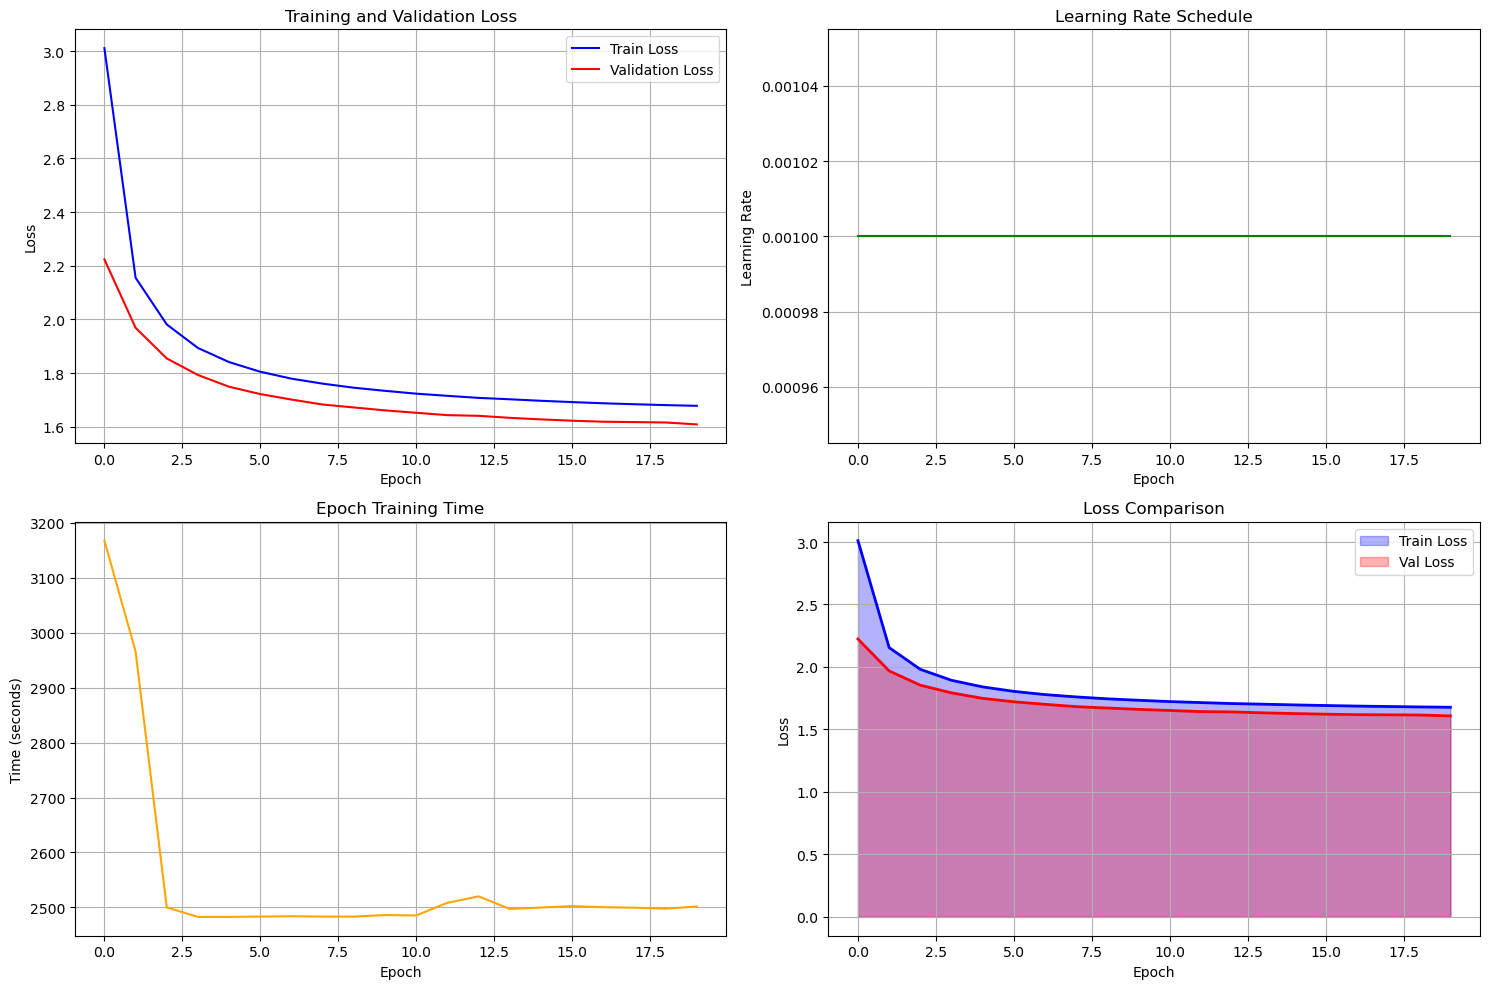

In [5]:
# Train the model with comprehensive training loop

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Trainer:
    """
    Trainer class for Seq2Seq machine translation model
    """
    def __init__(self, model, train_dataloader, val_dataloader, device,
                 learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device

        # Loss function - ignore padding tokens (index 0)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')

        # Optimizer
        self.optimizer = optim.Adam(model.parameters(),
                                  lr=learning_rate,
                                  weight_decay=weight_decay)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2
        )

        # Training history
        self.history = defaultdict(list)

    def calculate_loss(self, outputs, targets, target_lengths=None):
        """Calculate loss for the batch"""
        # outputs: [batch_size, seq_len, decoder_vocab_size]
        # targets: [batch_size, seq_len]
        # Reshape for loss calculation (use reshape instead of view for non-contiguous tensors)
        '''
        outputs.reshape(-1, outputs.size(-1)) 的作用：
            这个操作的主要目的是将多维张量展平为二维张量，以便进行后续的损失计算。
            具体分析
                假设 outputs 的形状是 [batch_size, seq_len, vocab_size]，例如 [128, 100, 21128]：
                1.outputs.size(-1):
                    获取最后一个维度的大小，即 vocab_size (21128)
                    等同于 outputs.size(2)
                2.reshape(-1, outputs.size(-1)):
                    -1 表示该维度大小由系统自动推断
                    第二个维度明确指定为 vocab_size
                    将张量从 [batch_size, seq_len, vocab_size] 重塑为 [batch_size * seq_len, vocab_size]
        '''
        outputs_flat = outputs.reshape(-1, outputs.size(-1))  # [batch_size * seq_len, decoder_vocab_size]
        targets_flat = targets.reshape(-1)  # [batch_size * seq_len]

        # Calculate loss
        loss = self.criterion(outputs_flat, targets_flat)

        return loss

    # 一个迭代训练步骤
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        # 一个epoch的总损失
        epoch_loss = 0.0
        # 一个epoch的总批次数
        num_batches = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)

        # 处理一个批次
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            source_ids = batch['source_ids'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass with teacher forcing
            decoder_input = target_ids[:, :-1]  # Remove last token
            decoder_targets = target_ids[:, 1:]  # Remove first token (BOS)

            outputs = self.model(source_ids, decoder_input)
            # outputs：[batch_size, target_len, vocab_size]

            # Calculate loss
            loss = self.calculate_loss(outputs, decoder_targets)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Update parameters
            self.optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_loss / num_batches:.4f}'
            })

            # Memory cleanup
            if batch_idx % 100 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Calculate average loss，评估该轮的训练效果
        return epoch_loss / num_batches

    # Validate for one epoch
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validation", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                source_ids = batch['source_ids'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)

                # Forward pass
                decoder_input = target_ids[:, :-1]
                decoder_targets = target_ids[:, 1:]

                outputs = self.model(source_ids, decoder_input)

                # Calculate loss
                loss = self.calculate_loss(outputs, decoder_targets)

                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1

                # Update progress bar
                progress_bar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'Avg Val Loss': f'{epoch_loss / num_batches:.4f}'
                })

        return epoch_loss / num_batches

    def train(self, num_epochs=10, save_path=None):
        """Train the model for specified number of epochs"""
        print(f"=== Starting Training for {num_epochs} Epochs ===")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_dataloader)}")
        print(f"Validation batches: {len(self.val_dataloader)}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print("=" * 60)

        best_val_loss = float('inf')
        start_time = time.time()

        # 训练N轮
        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)

            # Train
            train_loss = self.train_epoch()

            # Validate
            val_loss = self.validate_epoch()

            # Update learning rate scheduler
            self.scheduler.step(val_loss)

            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch_time'].append(epoch_time)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Epoch Time: {epoch_time:.2f}s")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best validation loss: {best_val_loss:.4f}")

                if save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'model_config': model_config
                    }, save_path)
                    print(f"Model saved to {save_path}")

            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Training summary
        total_time = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} min)")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {self.history['val_loss'][-1]:.4f}")

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history to plot")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Plot learning rate
        axes[0, 1].plot(self.history['learning_rate'], color='green')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True)

        # Plot epoch time
        axes[1, 0].plot(self.history['epoch_time'], color='orange')
        axes[1, 0].set_title('Epoch Training Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True)

        # Plot loss comparison
        x = range(len(self.history['train_loss']))
        axes[1, 1].fill_between(x, self.history['train_loss'], alpha=0.3, color='blue', label='Train Loss')
        axes[1, 1].fill_between(x, self.history['val_loss'], alpha=0.3, color='red', label='Val Loss')
        axes[1, 1].plot(self.history['train_loss'], color='blue', linewidth=2)
        axes[1, 1].plot(self.history['val_loss'], color='red', linewidth=2)
        axes[1, 1].set_title('Loss Comparison')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=1e-3,
    weight_decay=1e-5
)

# Start training for 10 epochs
print("Starting training...")
history = trainer.train(num_epochs=20, save_path="best_seq2seq_attention_model.pth")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history()


In [6]:
# import torch
# import gc
#
# # 查看当前GPU内存使用情况
# if torch.cuda.is_available():
#     print(f"GPU内存已分配: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
#     print(f"GPU内存缓存: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
#
# # 清理GPU缓存
# torch.cuda.empty_cache()
#
# # 强制垃圾回收
# gc.collect()
#
# # 查看当前GPU内存使用情况
# print("清理GPU缓存")
# if torch.cuda.is_available():
#     print(f"GPU内存已分配: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
#     print(f"GPU内存缓存: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")